In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\okarl\Desktop\diploma-thesis\ntbks`


In [2]:
using Plots
using StatsPlots
using JLD
using Statistics
using DataFrames
using ColorSchemes
using LaTeXStrings

In [3]:
DATA_PATH = "../results/"

function load_results(path, n_pars; bayes=false, adjusted=false)
    files = readdir(path)

    results = zeros(length(files), n_pars, 5)
    total_sims = 0

    for i in axes(files)[1]
        data = load(path * files[i])
        
        total_sims += sum(data["total_sims"])

        if adjusted
            data = data["adjusted_particles"]
        elseif bayes
            data = data["particles"]
        else
            data = data["parameters"]
        end

        # mean
        results[i, :, 1] = mean(data, dims=2)
        # median
        results[i, :, 2] = median(data, dims=2)
        # std
        results[i, :, 3] = std(data, dims=2)

        # credible interval/confidence interval
        results[i, :, 4] = hcat([quantile(data[i, :], 0.025) for i in 1:size(data, 1)]) # lower
        results[i, :, 5] = hcat([quantile(data[i, :], 0.975) for i in 1:size(data, 1)]) # upper
    end

    total_sims /= length(files)
    println(total_sims)
    return results
end;


function RMSE(true_params, parameters, stds)
    true_params = reshape(true_params, ((1, size(true_params)[1])))
    return mean(sqrt.(((parameters .- true_params).^2 + stds.^2) ./ abs.(true_params)))
end;

# AR2

phi_1 =  0.2  
phi_2 = -0.9  

In [4]:
TRUE_VALUES_AR2 = [0.2, -0.9];

In [5]:
print("ABC: ")
ar2_abc = load_results(DATA_PATH * "result_abc/ar2_abc/", 2, bayes=true, adjusted=true)
print("Bayes: ")
ar2_bayes = load_results(DATA_PATH * "result_bayes/ar2_bayes/", 2, bayes=true)
print("SMM: ")
ar2_smm = load_results(DATA_PATH * "result_smm/ar2_smm/", 2)
print("NPMSLE: ")
ar2_npmsle = load_results(DATA_PATH * "result_npmsle/ar2_npmsle/", 2);

ABC: 384867.28
Bayes: 300000.0
SMM: 384096.0
NPMSLE: 384096.0


In [6]:
index_level_1 = ["True", "Mean", "Mean", "Mean", "Mean", "Median", "Median", "Median", "Median", "Lower", "Upper", "Lower", "Upper", "Lower", "Upper", "Lower", "Upper", "Std", "Std", "Std", "Std"]
index_level_2 = ["True", "SMM", "NPMSL", "ABC", "Bayes", "SMM", "NPMSL", "ABC", "Bayes", "SMM", "SMM", "NPMSL", "NPMSL", "ABC", "ABC", "Bayes", "Bayes", "SMM", "NPMSL", "ABC", "Bayes"]


column_values = zeros(length(index_level_1), 2)
column_values[1, :] = TRUE_VALUES_AR2

for (i, data) in enumerate([ar2_smm, ar2_npmsle, ar2_abc, ar2_bayes])
    temp = round.(mean(data, dims=1)[1, :, :], digits=4)

    index = i + 1
    column_values[index, :] = temp[:, 1] # mean
    column_values[index + 4, :] = temp[:, 2] # median
    column_values[index + 8 + i - 1, :] = temp[:, 4] # lower
    column_values[index + 9 + i - 1, :] = temp[:, 5] # upper
    column_values[index + 16, :] = temp[:, 3] # std   
end

ar2_df = DataFrame(Index1=index_level_1, Index2=index_level_2, Psi_1=column_values[:, 1], Psi_2=column_values[:, 2]);

In [7]:
rmse_smm_mean = RMSE(TRUE_VALUES_AR2, mean(ar2_smm[:, :, 1], dims=1), std(ar2_smm[:, :, 1], dims=1))
rmse_smm_med = RMSE(TRUE_VALUES_AR2, mean(ar2_smm[:, :, 2], dims=1), std(ar2_smm[:, :, 2], dims=1))

rmse_npmsle_mean = RMSE(TRUE_VALUES_AR2, mean(ar2_npmsle[:, :, 1], dims=1), std(ar2_npmsle[:, :, 1], dims=1))
rmse_npmsle_med = RMSE(TRUE_VALUES_AR2, mean(ar2_npmsle[:, :, 2], dims=1), std(ar2_npmsle[:, :, 2], dims=1))

rmse_abc_mean = RMSE(TRUE_VALUES_AR2, mean(ar2_abc[:, :, 1], dims=1), std(ar2_abc[:, :, 1], dims=1))
rmse_abc_med = RMSE(TRUE_VALUES_AR2, mean(ar2_abc[:, :, 2], dims=1), std(ar2_abc[:, :, 2], dims=1));

rmse_bayes_mean = RMSE(TRUE_VALUES_AR2, mean(ar2_bayes[:, :, 1], dims=1), std(ar2_bayes[:, :, 1], dims=1))
rmse_bayes_med = RMSE(TRUE_VALUES_AR2, mean(ar2_bayes[:, :, 2], dims=1), std(ar2_bayes[:, :, 2], dims=1));

In [8]:
ols_ar = load(DATA_PATH * "ols_ar2.jld")["estimates"]  # ols estimates

palette = cgrad(:Set1_4, 4, categorical=true).colors

p1_mean = density(ar2_smm[:, 1, 1], label="SMM", color=palette[1], linewidth=1.5)
density!(p1_mean, ar2_npmsle[:, 1, 1], label="NMSLE", color=palette[2], linewidth=1.5)
density!(p1_mean, ar2_abc[:, 1, 1], label="ABC", color=palette[3], linewidth=1.5)
density!(p1_mean, ar2_bayes[:, 1, 1], label="Bayes", color=palette[4], linewidth=1.5)
density!(p1_mean, ols_ar[:, 1], label="OLS", color=:grey30, linewidth=1.5)
plot!(p1_mean, [TRUE_VALUES_AR2[1]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p1_mean, L"\psi_1" * "\n", titlefontsize=24)

p2_mean = density(ar2_smm[:, 2, 1], label="SMM", color=palette[1], linewidth=1.5)
density!(p2_mean, ar2_npmsle[:, 2, 1], label="NMSLE", color=palette[2], linewidth=1.5)
density!(p2_mean, ar2_abc[:, 2, 1], label="ABC", color=palette[3], linewidth=1.5)
density!(p2_mean, ar2_bayes[:, 2, 1], label="Bayes", color=palette[4], linewidth=1.5)
density!(p2_mean, ols_ar[:, 2], label="OLS", color=:grey30, linewidth=1.5)
plot!(p2_mean, [TRUE_VALUES_AR2[2]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p2_mean, L"\psi_2" * "\n", titlefontsize=24)

plot_layout = (2)
plot_ar2_mean =plot(p1_mean, p2_mean,
    layout = plot_layout,
    legend=true, size=(700,400)
);


p1_med = density(ar2_smm[:, 1, 2], label="SMM", color=palette[1], linewidth=1.5)
density!(p1_med, ar2_npmsle[:, 1, 2], label="NPMSLE", color=palette[2], linewidth=1.5)
density!(p1_med, ar2_abc[:, 1, 2], label="ABC", color=palette[3], linewidth=1.5)
density!(p1_med, ar2_bayes[:, 1, 2], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p1_med, [TRUE_VALUES_AR2[1]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p1_med, L"\psi_1" * "\n", titlefontsize=24)

p2_med = density(ar2_smm[:, 2, 2], label="SMM", color=palette[1], linewidth=1.5)
density!(p2_med, ar2_npmsle[:, 2, 2], label="NPMSLE", color=palette[2], linewidth=1.5)
density!(p2_med, ar2_abc[:, 2, 2], label="ABC", color=palette[3], linewidth=1.5)
density!(p2_med, ar2_bayes[:, 2, 2], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p2_med, [TRUE_VALUES_AR2[2]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p2_med, L"\psi_2" * "\n", titlefontsize=24)

plot_layout = (2)
plot_ar2_med =plot(p1_med, p2_med,
    layout = plot_layout,
    legend=true, size=(700,400)
);

In [9]:
println(ar2_df)

21×4 DataFrame
 Row │ Index1  Index2  Psi_1    Psi_2   
     │ String  String  Float64  Float64 
─────┼──────────────────────────────────
   1 │ True    True     0.2     -0.9
   2 │ Mean    SMM      0.1993  -0.8991
   3 │ Mean    NPMSL    0.1994  -0.8988
   4 │ Mean    ABC      0.1994  -0.8992
   5 │ Mean    Bayes    0.1997  -0.8988
   6 │ Median  SMM      0.1993  -0.8991
   7 │ Median  NPMSL    0.1994  -0.8989
   8 │ Median  ABC      0.1994  -0.8992
   9 │ Median  Bayes    0.1997  -0.8988
  10 │ Lower   SMM      0.1978  -0.9003
  11 │ Upper   SMM      0.2007  -0.8977
  12 │ Lower   NPMSL    0.1947  -0.9035
  13 │ Upper   NPMSL    0.2042  -0.8942
  14 │ Lower   ABC      0.1986  -0.8999
  15 │ Upper   ABC      0.2001  -0.8985
  16 │ Lower   Bayes    0.1834  -0.9148
  17 │ Upper   Bayes    0.2158  -0.8826
  18 │ Std     SMM      0.0007   0.0007
  19 │ Std     NPMSL    0.0025   0.0025
  20 │ Std     ABC      0.0004   0.0004
  21 │ Std     Bayes    0.0083   0.0083


In [10]:
println("Mean parameters RMSE")
println("SMM:     $rmse_smm_mean")
println("NMSLE:   $rmse_npmsle_mean")
println("ABC:     $rmse_abc_mean")
println("Bayes:   $rmse_bayes_mean")
println()
println("Median parameters RMSE")
println("SMM:     $rmse_smm_med")
println("NMSLE:   $rmse_npmsle_med")
println("ABC:     $rmse_abc_med")
println("Bayes:   $rmse_bayes_med")

Mean parameters RMSE
SMM:     0.014156216826422645
NMSLE:   0.013351346867289181
ABC:     0.013456406143283965
Bayes:   0.013901384374114409

Median parameters RMSE
SMM:     0.01414904383959027
NMSLE:   0.013352066938204957
ABC:     0.013456503900069292
Bayes:   0.013873166839091608


### Mean parameters

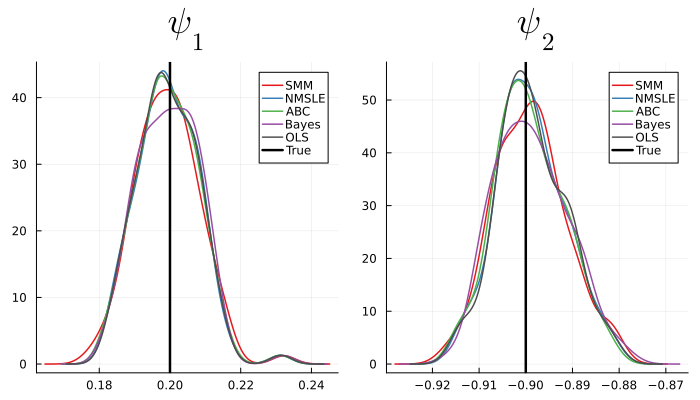

In [11]:
plot_ar2_mean

In [12]:
savefig(plot_ar2_mean, "../plots/ar2_plot_mean.png")

"C:\\Users\\okarl\\Desktop\\diploma-thesis\\plots\\ar2_plot_mean.png"

### Median parameters

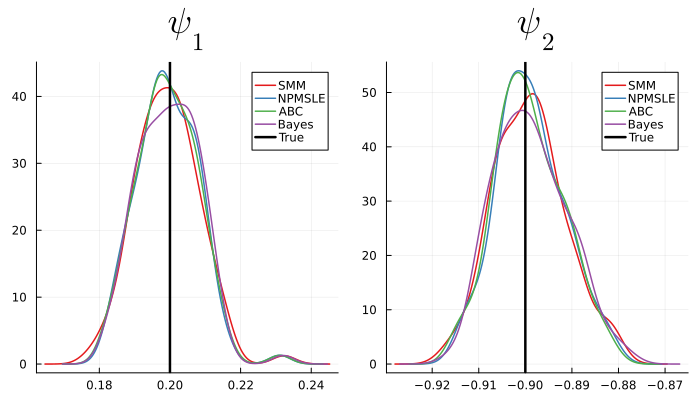

In [13]:
plot_ar2_med